# Init

## Imports

In [1]:
from vpython import *
import numpy as np
import pandas as pd

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Set Up

In [277]:
# Definition of parameters
T0  = 3600 * 24
R0  = 1.e10
rM0 = 4.6    # in units of R0
vM0 = 58.98e3 *T0 / R0; print(vM0)
TM  = 88.    # in units of T0
rS  = 2.95e-7  # in units of R0
c   = 2.998e8 * T0/R0; print(c)
aM  = c**2 / 2 *rS; print(aM)  # in units of R0**3/T0**2
h   = (rM0*vM0/c)**2; print(h)

print( "h/rM0**2 = {0:1.1e}".format(h/rM0**2))
print( "rS/rM0 = {0:1.1e}".format(rS/rM0))
print( h)

0.5095872
2590.272
0.9896525825126399
8.189585904056118e-07
h/rM0**2 = 3.9e-08
rS/rM0 = 6.4e-08
8.189585904056118e-07


In [276]:


# Initialize distance and velocity vectors
vec_rM0 = vector(0, rM0, 0)
vec_vM0 = vector(vM0, 0, 0)

# Definition of the time step
dt0    = 2. * vM0 / aM
alpha0 = 0. 
beta0  = 0.

# Define the function
def evolve_mercury(vec_rM_old, vec_vM_old, dt=dt0, alpha=alpha0, beta=beta0):
    # Compute the strength of the acceleration      
    aMS = aM * ( 1. + alpha * rS / vec_rM_old.mag + beta * h / vec_rM_old.mag **2  ) / vec_rM_old.mag**2
    # Multiply by the direction
    vec_aMS = - aMS * ( vec_rM_old / vec_rM_old.mag )
    # Update velocity vector
    vec_vM_new = vec_vM_old + vec_aMS * dt
    # Update position vector
    vec_rM_new = vec_rM_old + vec_vM_new * dt
    return vec_rM_new, vec_vM_new

# define function for angle extraction
def angle_between(v1, v2):
    return acos( dot(v1, v2) / (v1.mag * v2.mag) ) * 180. / pi

def get_delta_Theta(dt, alpha=0.0, beta=0.0):
    # Run parameters
    vec_r_last = vec_rM0
    turns      = 0
    max_turns  = 10
    list_perih = list()
    list_angle = list()
    sum_angle  = 0.
    TM = list()
    t0 = 0.
    t = 0.
    
    # define the initial coordinates; M = mercury, S = sun
    Mpos = vec_rM0
    Mvel = vec_vM0

    # find perihelion for each turn an print it out
    while turns <= max_turns:
        t += dt
        vec_r_before_last = vec_r_last
        vec_r_last        = vector(Mpos)
        # update the velocity and position
        Mpos , Mvel = evolve_mercury(Mpos , Mvel , dt=dt, alpha=alpha, beta=beta)
        # check if at perihelion
        if vec_r_before_last.mag > vec_r_last.mag < Mpos.mag:
            turns = turns+1
            list_perih.append(vec_r_last)
            if turns > 1:
                TM.append(t-t0)
                # draw location of perihelion
                sphere(color=color.green, radius=0.2, pos=vec_r_last)
                # display intermediate results
                list_angle.append(angle_between(list_perih[-2],list_perih[-1]))
                #print("turn: n={n}, perihilion growth: delta Theta={angle}".format(
                #    n=turns, angle=list_angle[-1]
                #))
                # note that list_perih[-2] acces the second last and
                #  list_perih[-1] the last element in the list
            t0 = t
    avg_angle=np.sum(list_angle)/len(list_angle)
    TM = np.sum(TM)/len(TM)
    # display the average
    #print("--------------------------------")
    #print("average perihilion growth: delta Theta={avg}".format(avg=avg_angle))
    return np.array(list_angle), TM

0.5095872
2590.272
0.9896525825126399
8.189585904056118e-07
h/rM0**2 = 3.9e-08
rS/rM0 = 6.4e-08
8.189585904056118e-07


# Farming

In [142]:
dt_steps = [dt0/n for n in [1,10,100,200,500]]
alphas   = np.array(list(np.linspace(1.e4, 1.e5, 10)) + list(np.linspace(2.e5, 1.e6, 9)))
alphas   = np.insert(alphas, [0], [0])

data = list()

alpha = 0.0

for dt in dt_steps:
    for par in alphas:
        for alpha, beta in [(0.0, par),(par, 0.0)]:
            angles, TM = get_delta_Theta(dt, alpha=alpha, beta=beta)
            data.append({
                "dt": dt,
                "alpha": alpha,
                "beta": beta,
                "avg": np.average(angles), 
                "std": np.std(angles),
                "angles": angles,
                "TM": TM
            })

df = pd.DataFrame(data)
df.drop(index=0, axis=1, inplace=True)
df.head()

KeyboardInterrupt: 

# Plotting

In [143]:
import seaborn as sns
import matplotlib
import matplotlib.pylab as plt
import re
import pandas as pd
import numpy as np

font="Times"
sns.set(
    style="ticks", 
    font_scale=0.8,
)

matplotlib.rcParams['mathtext.fontset'] = 'cm'
font = {'family':'serif', 'serif': ['times new roman'], 'style': 'normal', 'variant': 'normal', 'weight': 'ultralight'}
plt.rc('font',**font)

cm2inch = lambda cm: cm/2.54

a4w = cm2inch(210./10) #mm
a4h = cm2inch(297./10) #mm

# Definition of parameters
T0  = 3600. * 24
R0  = 1.e10
rM0 = 4.6    # in units of R0
vM0 = 58.98e3 *T0 / R0
TM  = 88.    # in units of T0
rS  = 2.95e-7  # in units of R0
c = 2.998e8 * T0/R0 
aM  = c**2 / 2 *rS  # in units of R0**3/T0**2
h   = (rM0*vM0/c)**2

dt0 = 2.*vM0/aM

## Linear Interpolation

In [144]:
df = pd.read_csv("mercury_orbit_analysis_final.csv")

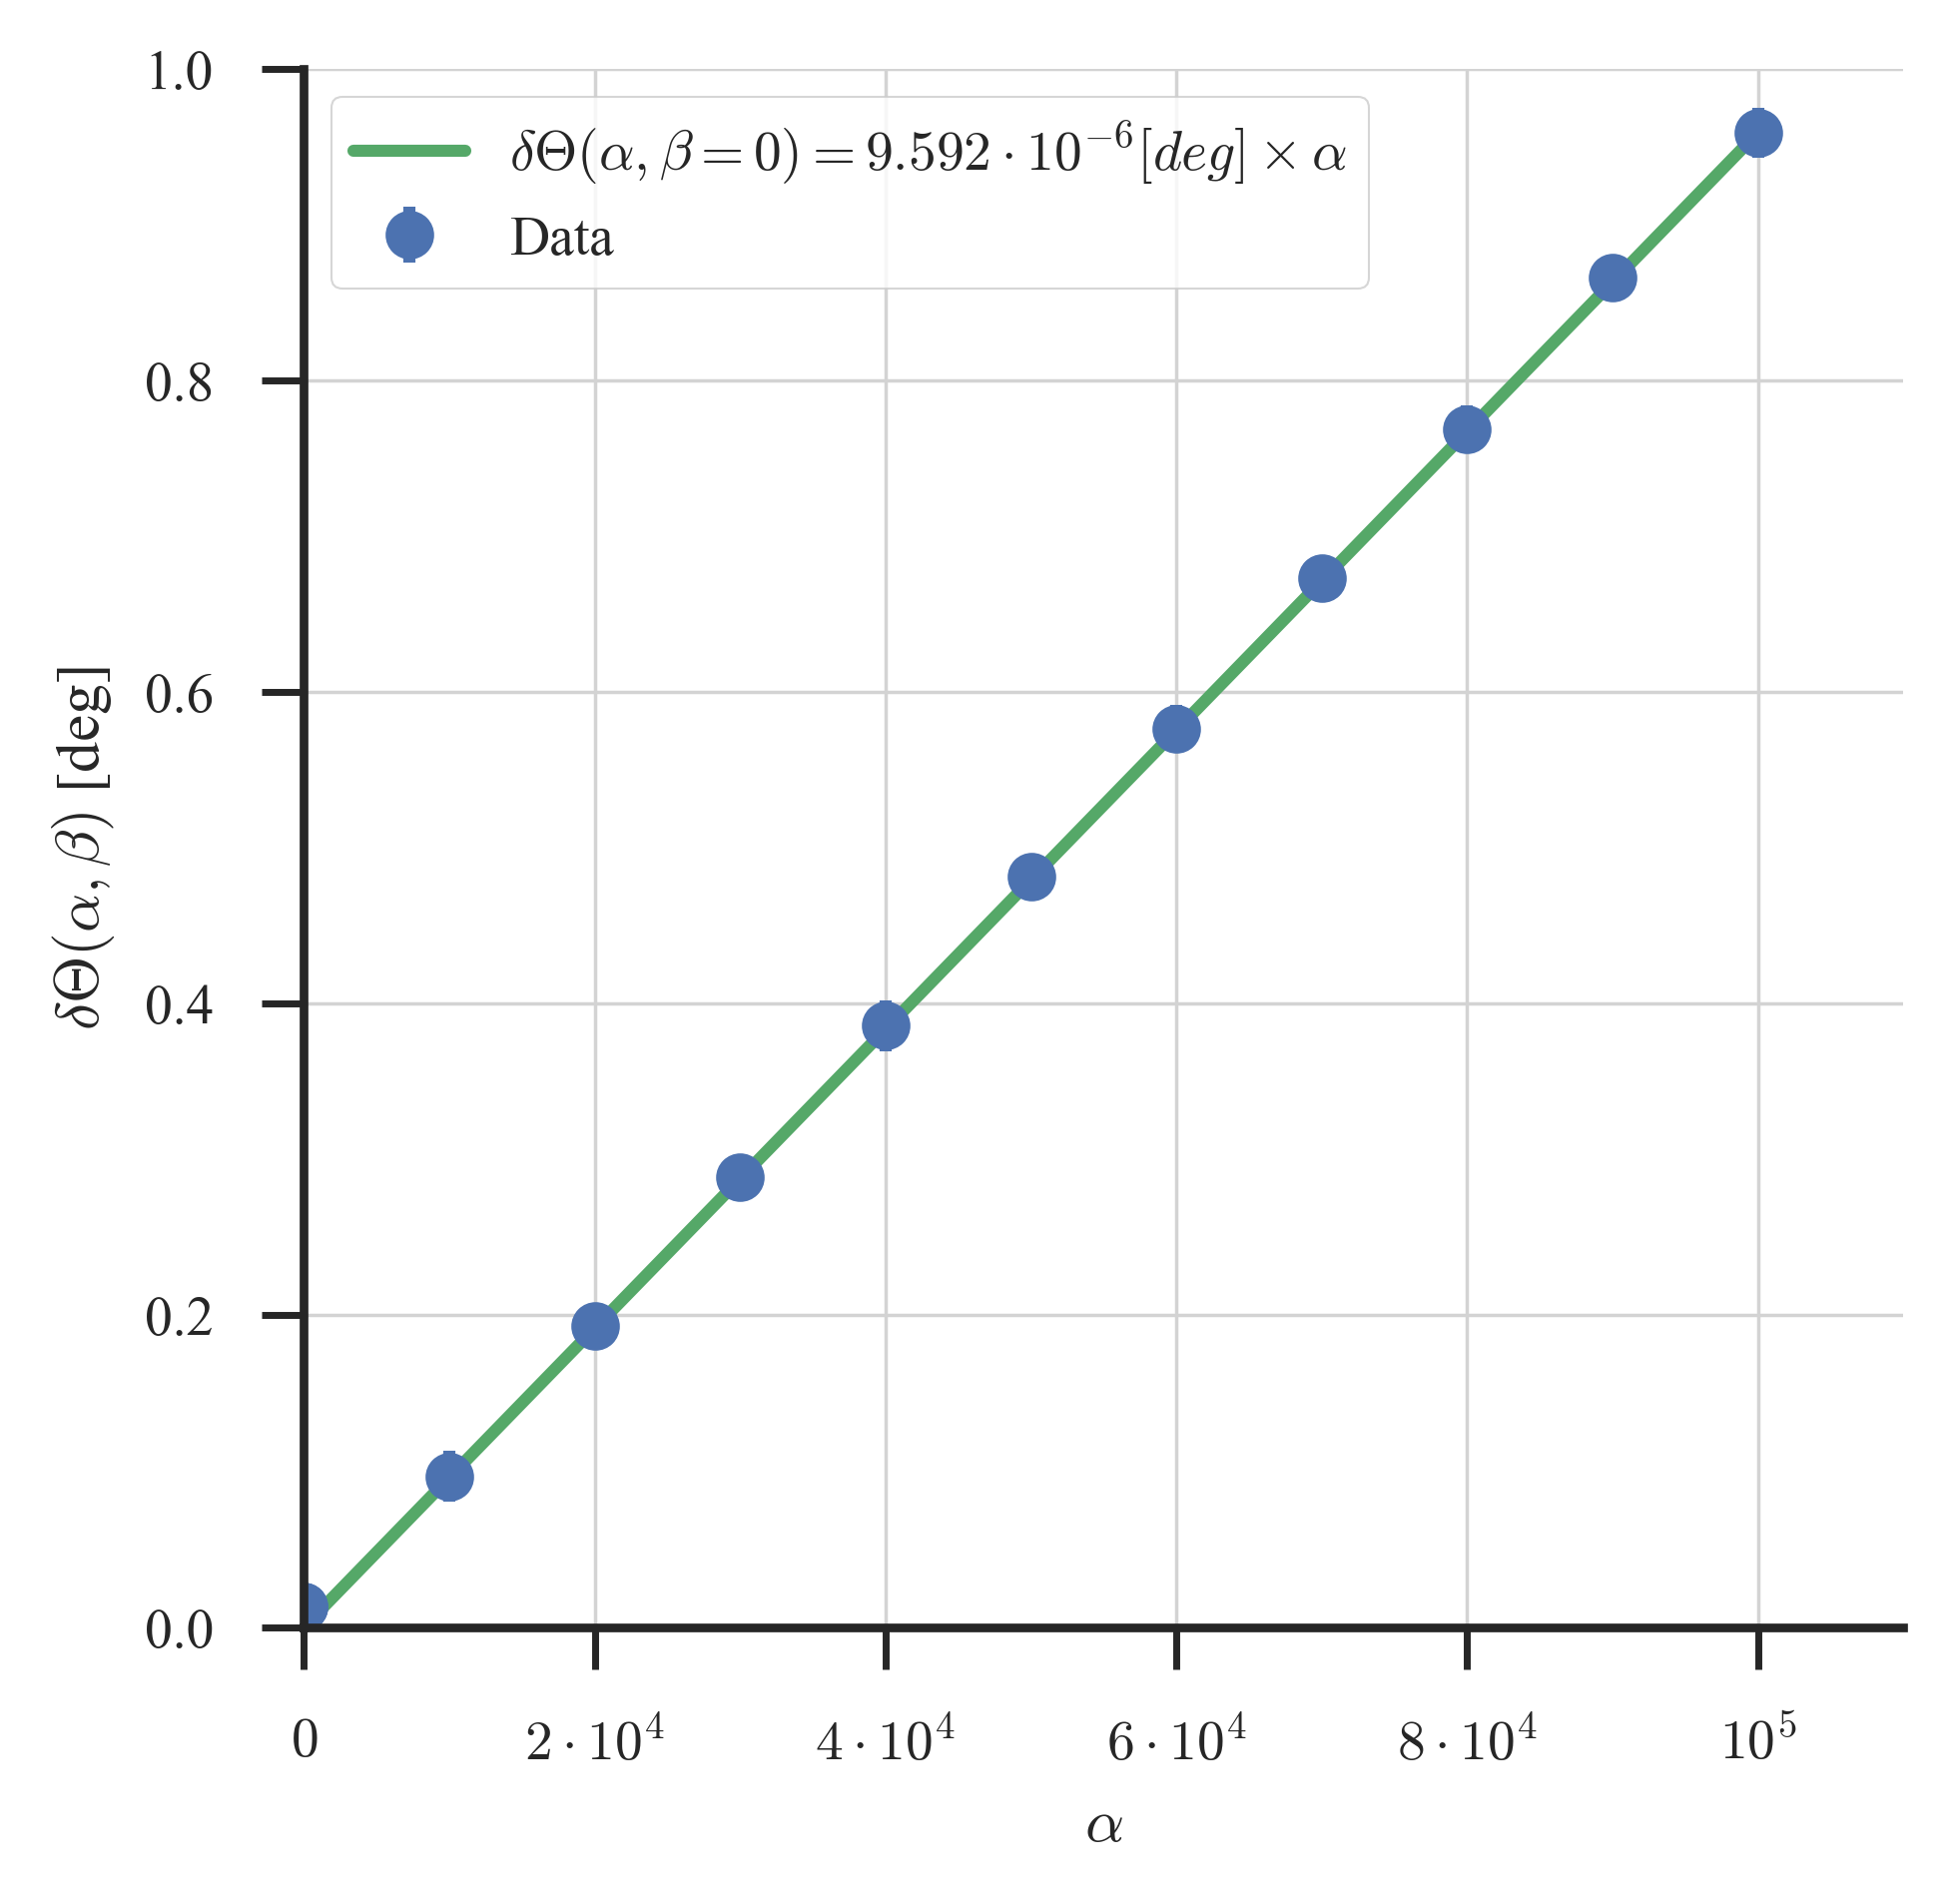

In [267]:
fig = plt.figure(figsize=(a4w*0.5, a4w*0.5), dpi=500)

#par    ="beta"
#notpar ="alpha"
notpar ="beta"
par    ="alpha"

dt  = dt0 / 200
val = 1.e5 

tf = df.query("dt == @dt and {notpar}==0.0".format(notpar=notpar))
m  = tf.query("{par}==@val".format(par=par))["avg"].as_matrix()[0]/val

alpha_lin = np.linspace(0,val,400)
theta_lin = m*alpha_lin

ax = fig.gca()

if par == "alpha":
    alphaval=""
    betaval="=0"
else:
    alphaval="=0"
    betaval=""  

fit_label=r"$\delta \Theta(\{par}) = {m:1.3e} \times \{par}$".format(m=m, par=par)
base, exp = re.findall("([0-9\.]+)e([\-0-9]+)",fit_label)[0]
fit_label=r"$\delta \Theta(\alpha {alphaval},\beta {betaval}) = {base:1.3f} \cdot 10^{{{exp:d}}} [deg] \times \{par}$".format(
    base=float(base), exp=int(exp), par=par, notpar=notpar, alphaval=alphaval, betaval=betaval
)

ax.errorbar(tf[par], tf["avg"], tf["std"], marker="o", linestyle="None", label="Data")
ax.plot(alpha_lin, theta_lin, label=fit_label)
#ax.plot(tf[par], tf["avg"],  marker="o", linestyle="None", label="Data")

ax.grid(color='lightgray', linestyle='-', linewidth=0.5)

sns.despine()

ax.set_xlim(0, val*1.1)
ax.set_ylim(0,1)

ax.set_ylabel(r"$\delta \Theta(\alpha, \beta)$ [deg]".format(par=par))
ax.set_xlabel(r"$\{par}$".format(par=par))

ax.set_xticklabels(["$0$"]+["${n}\cdot10^{{4}}$".format(n=n) for n in range(2,10,2)]+["$10^{5}$"])

ax.legend(loc="upper left", frameon=True)

plt.show(fig)

# Timestep errors

In [187]:
len(df["beta"].unique())

20

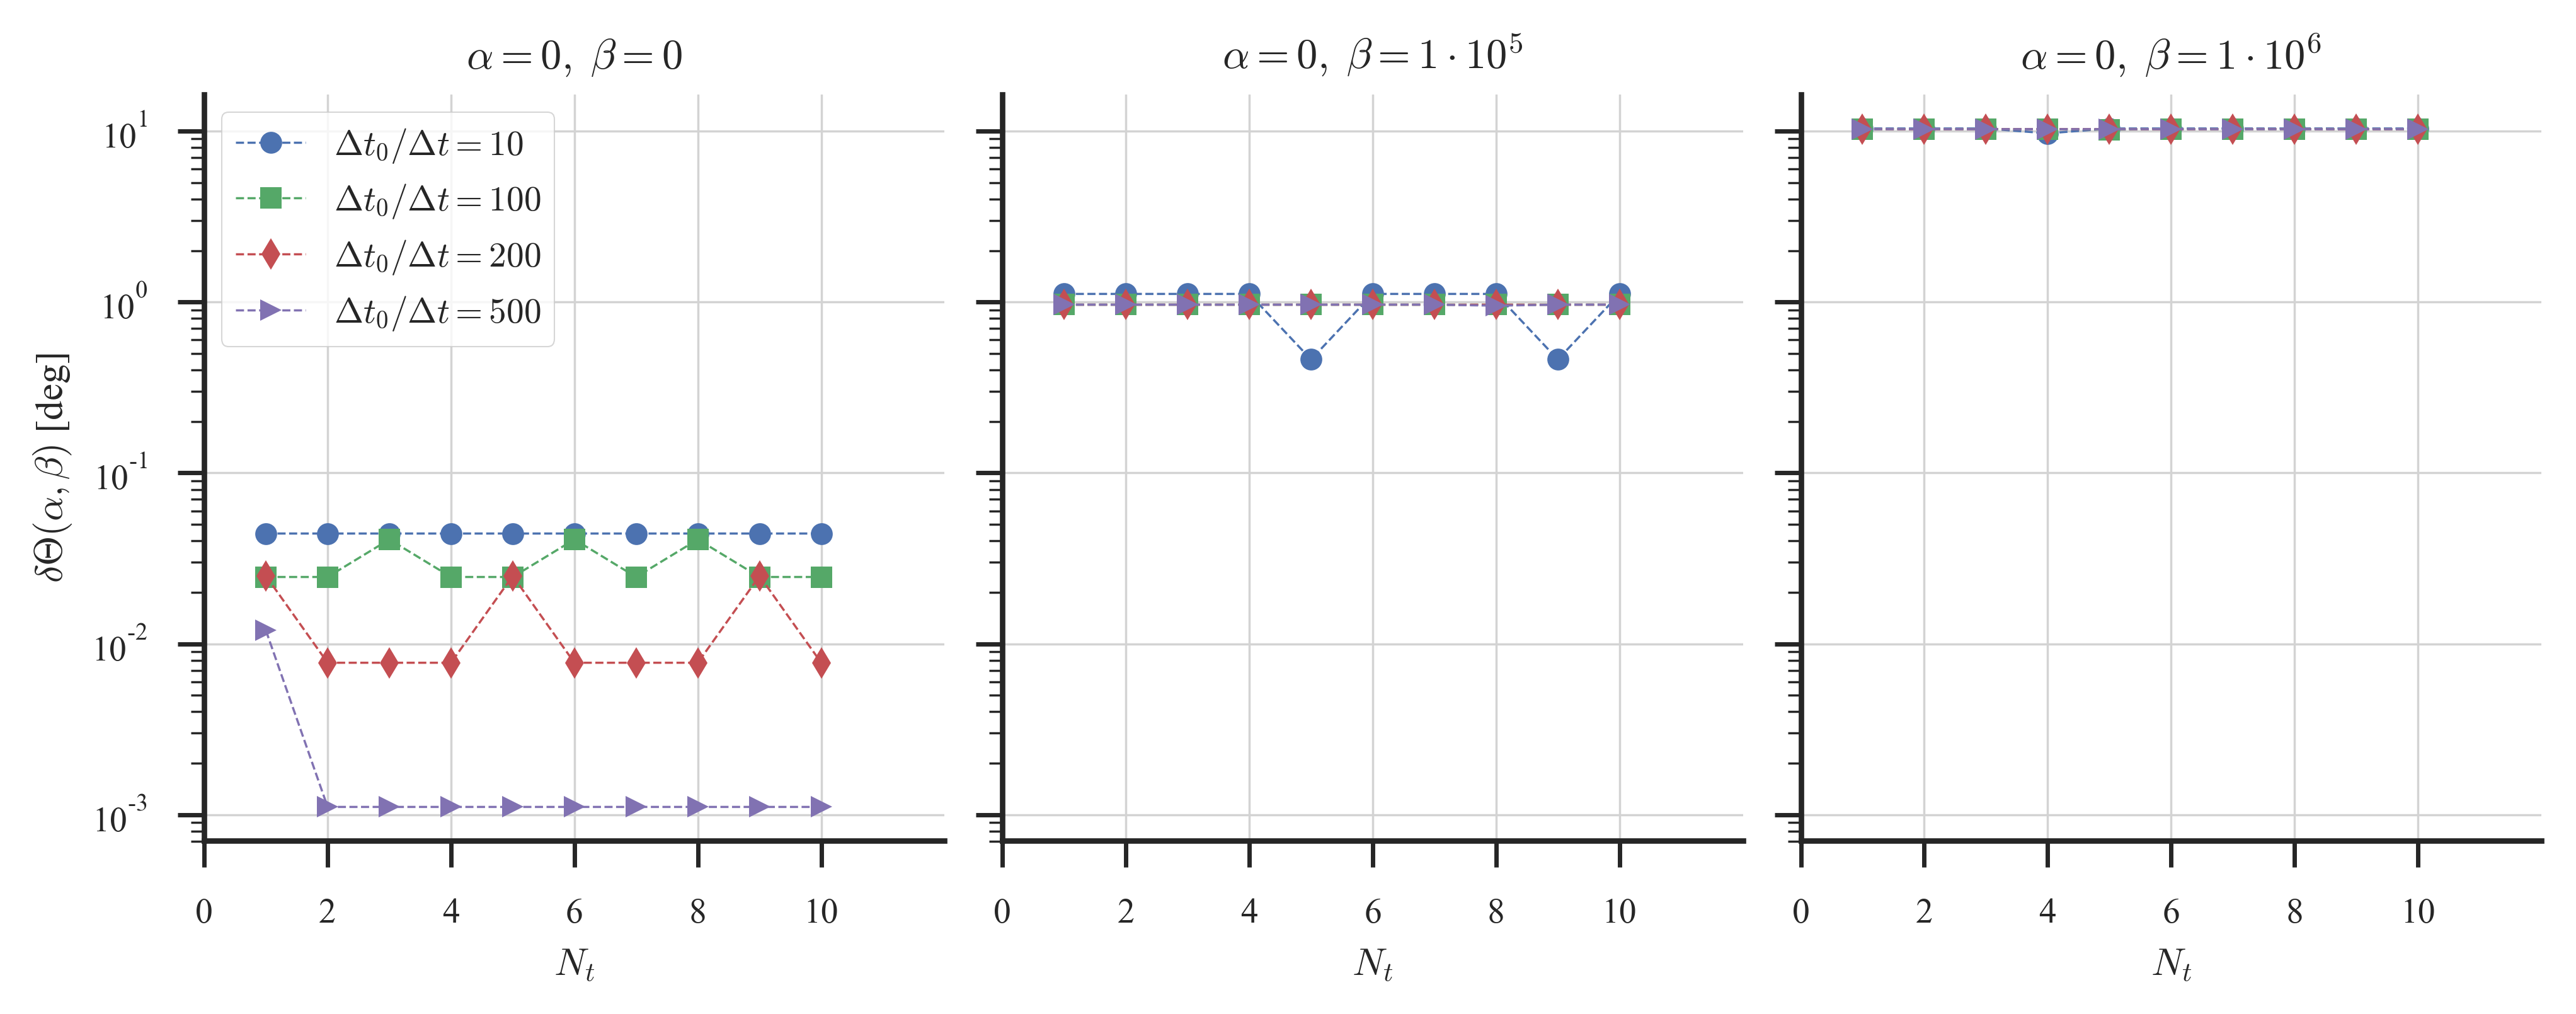

In [189]:
fig, axs = plt.subplots(figsize=(a4w, a4w/2.5), dpi=500, ncols=3, nrows=1, sharex=True, sharey=True)

ax = fig.gca()

par    ="beta"
notpar ="alpha"

markers = {
    0: "o", 1:"s", 2:"d", 3: ">", 4:"<", 
}

for nax, (alpha, ax) in enumerate(zip(df[par].unique()[[0,10,19]], axs)):
    ax.set_xlabel(r"$N_t$")
    for ndt, dt in enumerate(df["dt"].unique()[1:]):
        tf = df.query("dt == @dt and {par} == @alpha and {notpar} == 0".format(par=par, notpar=notpar))
        ind = tf.index[0]
        try:
            angles = [float(val) for val in re.findall("[0-9\.]+",tf.loc[ind, "angles"])]
        except:
            angles = tf.loc[ind, "angles"]
        ax.plot(
            range(1,11),
            angles, 
            marker=markers[ndt], ms=5,
            linestyle="--", 
            lw=0.5,
            label=r"$\Delta t_0/\Delta t ={0}$".format(ceil(dt0/dt))
        )
        if alpha==0:
            title=r"$\{notpar} = 0, \; \{par} = 0$".format(par=par, notpar=notpar)
        else:
            title=r"$\{notpar} = 0, \; \{par} = {0:1.0e}$".format(alpha, par=par, notpar=notpar)
        
        ax.set_title(re.sub("([0-9]+)e\+0([0-9]+)","\g<1> \cdot 10^{\g<2>}",title))
        ax.grid(color='lightgray', linestyle='-', linewidth=0.5)
        ax.set_xticks([0,2,4,6,8,10])
        ax.set_yscale("log")



sns.despine()

ax.set_xlim(0, 12)
#ax.set_ylim(0,15)


axs[0].set_ylabel(r"$\delta \Theta(\alpha, \beta)$ [deg]")
for n in range(1,4):
    pass#plt.setp(axs[n].get_yticklabels(),visible=False)

axs[0].legend(loc="upper left", frameon=True, fontsize="small")

plt.tight_layout()

plt.show(fig)

In [190]:
fig.savefig("angular-variaton.pdf", bbox_inches="tight")

## Diff plot

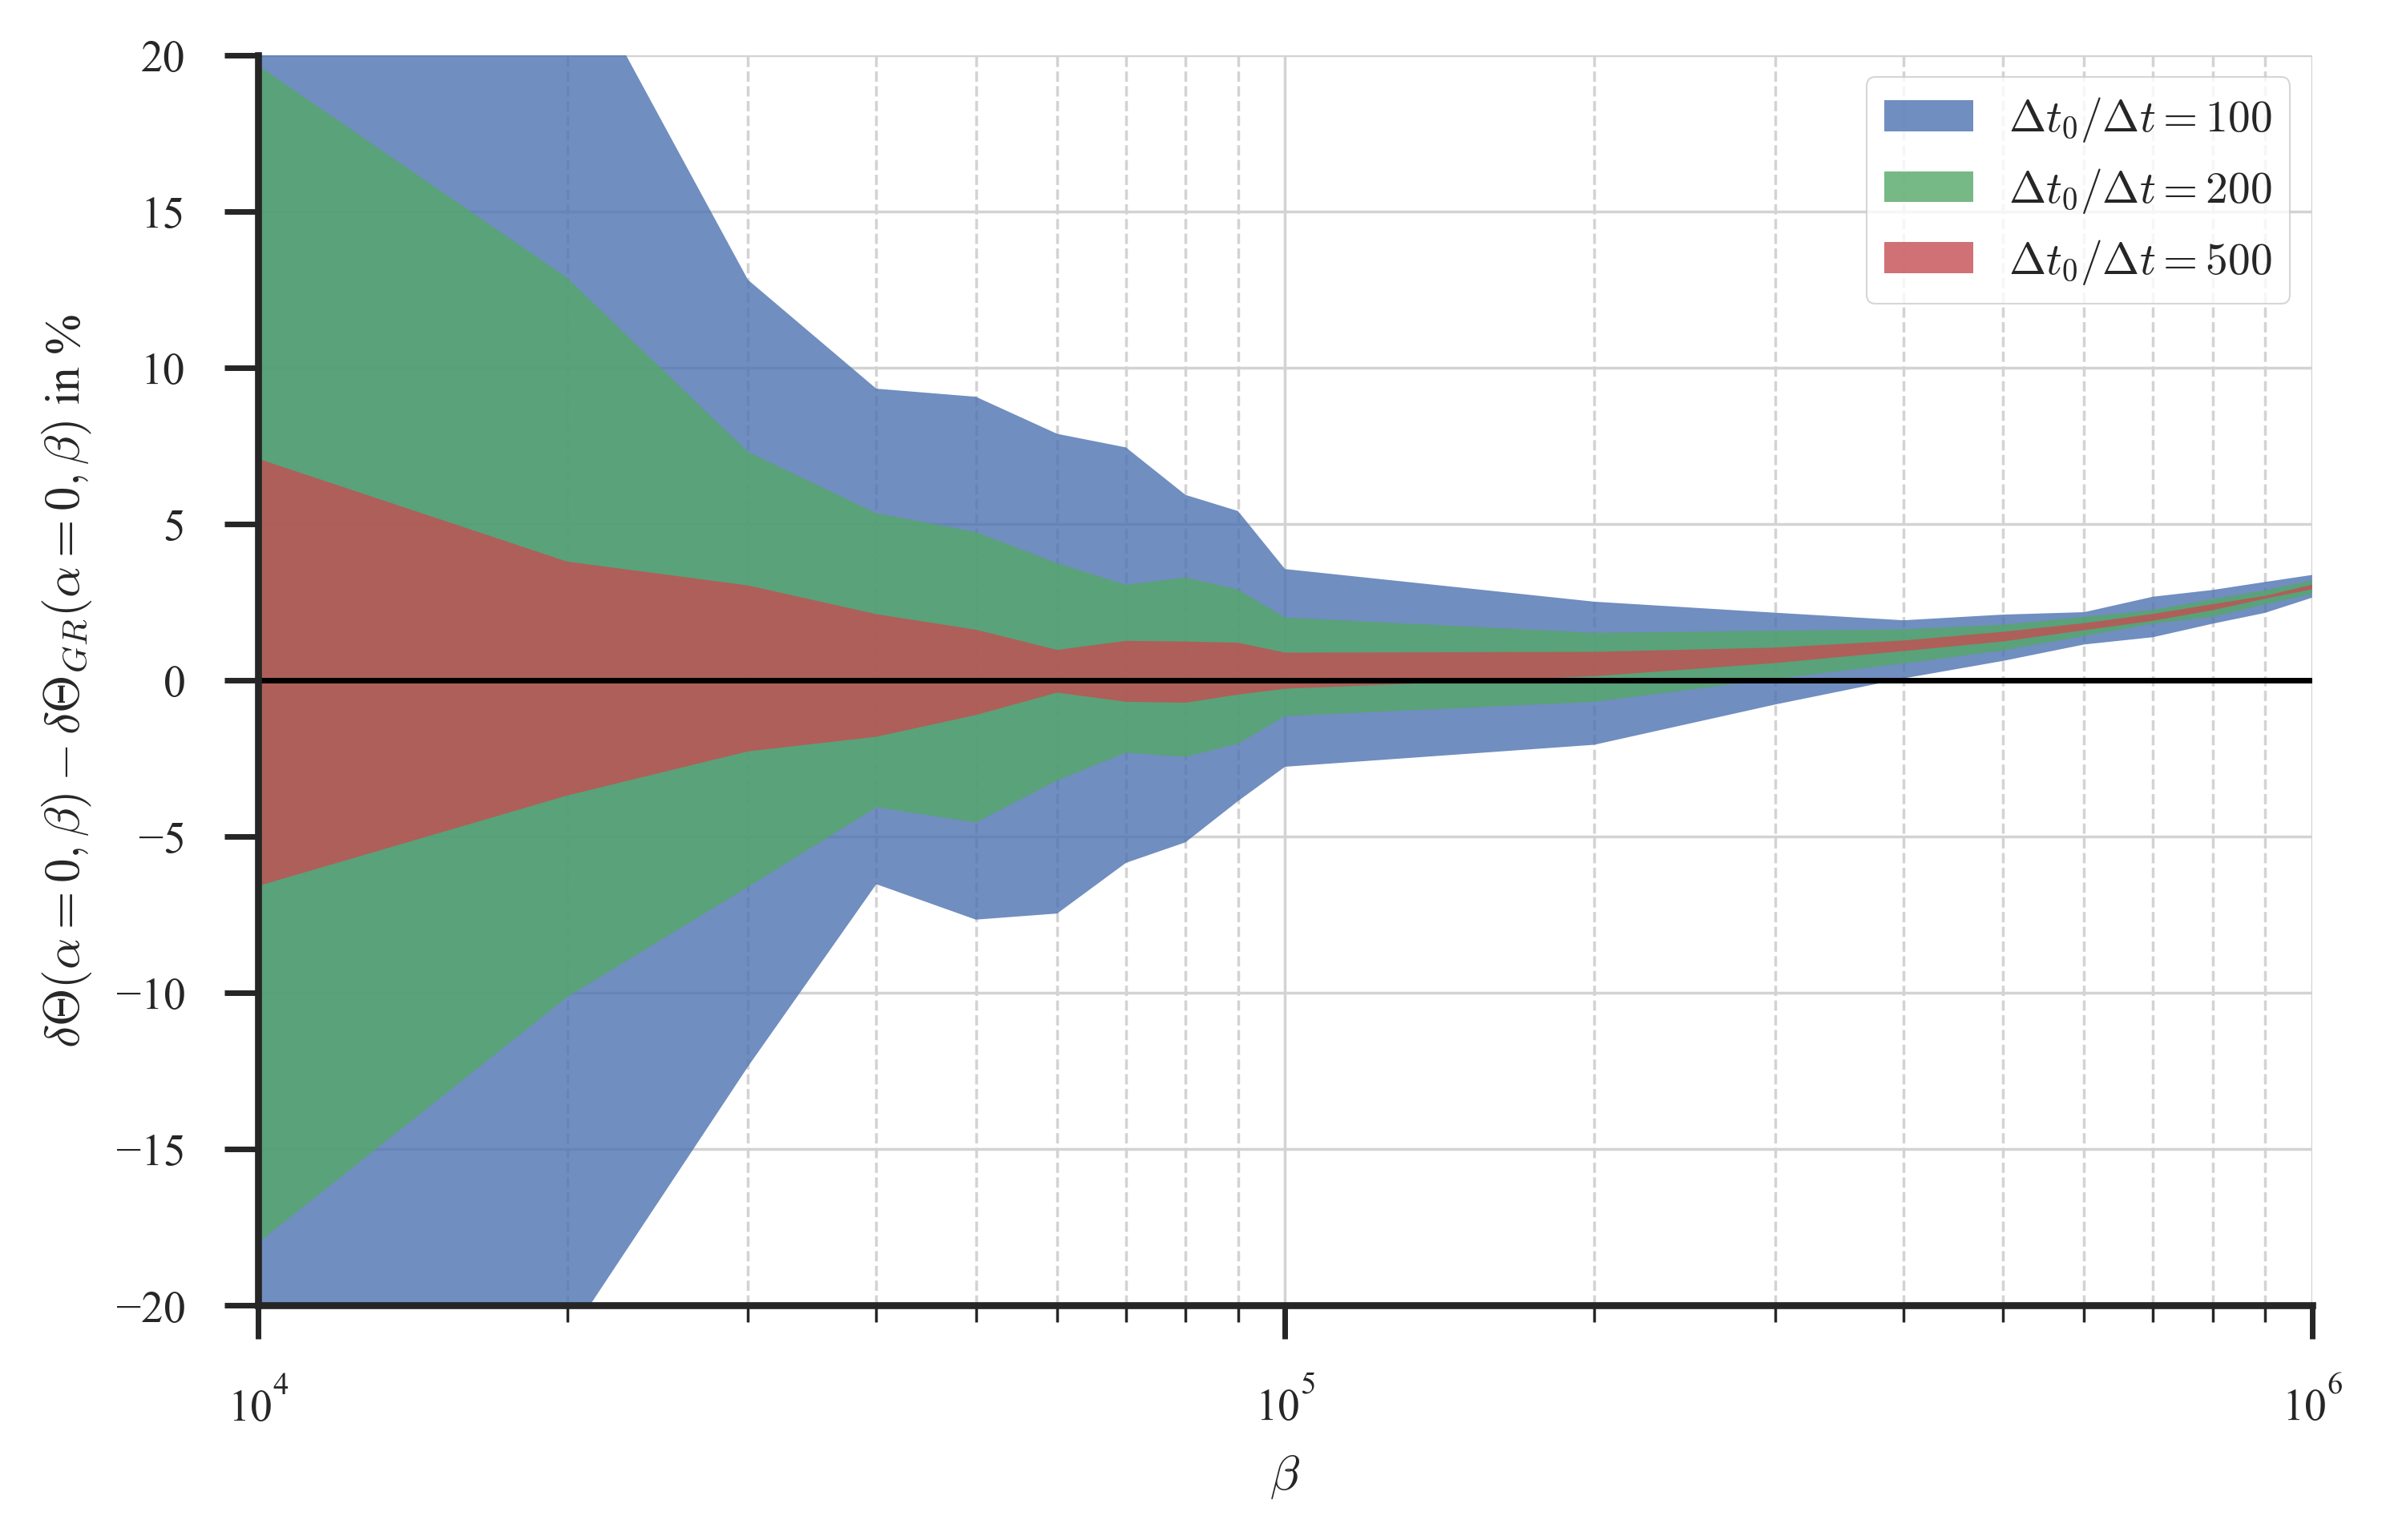

In [262]:
fig = plt.figure(figsize=(a4w*0.8, a4w*0.5), dpi=500)

ax = fig.gca()

betas   = df.beta.unique()

for dt in df.dt.unique()[2:]:
    diff  = []
    del_n = []
    for beta in betas[1:]:
        i0 = df.query("alpha == 0 and beta == 0 and dt == @dt").index[0]
        i1 = df.query("alpha == 0 and beta == @beta and dt == @dt").index[0]

        avg0 = df.loc[i0, "avg"]
        std0 = df.loc[i0, "std"]
        avg1 = df.loc[i1, "avg"]
        std1 = df.loc[i1, "std"]
        
        GR = (rS**2/4/h*beta + 3./32* rS**4/h**2 *beta**2 + 5./128*rS**6/h**3 * beta**3 )*360
        del_tot = np.sqrt(avg0**2 + std0**2 + std1**2)

        diff.append((avg1-GR)/GR*100)
        del_n.append((del_tot)/GR*100)
    
    ax.fill_between(
        betas[1:], 
        np.array(diff)+np.array(del_n), 
        np.array(diff)-np.array(del_n), 
        interpolate=True, 
        alpha=0.8,
        label=r"$\Delta t_0/\Delta t ={0}$".format(ceil(dt0/dt))
    )

    for cap in caps:
        cap.set_markeredgewidth(1)

ax.grid(color='lightgray', linestyle='-', linewidth=0.5, which="major")
ax.grid(color='lightgray', linestyle='--', linewidth=0.5, which="minor")
ax.axhline(0, linestyle="-", color="black", lw=1)

sns.despine()

ax.set_ylim(-20,20)
ax.set_xscale("log")
ax.set_xlim(1.e4, 1.e6)

ax.legend(loc="upper right", frameon=True, fontsize="small")

ax.set_ylabel(r"$\delta \Theta(\alpha=0, \beta)-\delta \Theta_{GR}(\alpha=0, \beta)$ in %")
ax.set_xlabel(r"$\beta$")

plt.show(fig)

In [263]:
fig.savefig("computation-precision.pdf", bbox_inches="tight")

In [273]:
print(0.964/10**5 * 3 * 3600)
0.964/10**5 * 3 * 3600* 100* 4.15 

0.104112


43.20648

In [296]:
a = [1,2,3]
np.std(a)

0.81649658092772603

In [297]:
avg = (1+2+3)/3
std = 0
for el in a:
    std += (el - avg)**2
np.sqrt(std/3.)

0.81649658092772603

In [ ]:
np.std()